## Merged Feature Engineering

This notebook merge _Brazil_ and _France_ dataset into a single training dataset.
It adds seasonal information (seasons, month), scale relevent features and removed unecessary columns.

> Note this notebook need ouputs from both _01a - Data Preprocessing Brazil_ and 01b - _Data Preprocessing France_

![Alt text](../images/notebook-2.png)

### 1. Data Import and Setup

Imports necessary libraries, sets up environment paths, and includes custom utility functions.


In [31]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(BASE_DIR)

from src.utils.plots import plot_water_flows
from src.utils.custom_models import SnowIndexComputeTransformer
from src.utils.plots import plot_cumulative_variance
from src.utils.helpers import add_lagged_features, add_lagged_features_per_station

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Defines constants :

- INPUT*DIR must be the same as the one defined in \_01 - Data Preprocessing* notebook.
- EVAL*DIR must be the same as the one defined in \_01 - Data Preprocessing* notebook.


In the following cell, the `DATASET_TRANSFORMS` list will be the reference for the transformations that will be applied to the dataset. Commenting a transformation will exclude it from the pipeline. You can refer to the commends next to each transformations for some general information about it.


In [32]:
INPUT_DIR = "../../../data/input/"
EVAL_DIR = "../../../data/evaluation/"
USE_CUSTOM_PREPROCESS = True
DATASET_TRANSFORMS = [
    "rm_gnv_st",  # Remove the geneva station (which is an outlier in the dataset) - Recommended
    "pca",  # Apply PCA to some of the static features (soil composition etc...) - Recommended
    "snow_index",  # Compute the snow index - probability of snow (which is a feature that's estimated from other features in the dataset) - Recommended
    # "snow_index_lag",  # Add lagged features of the snow index - Should be disabled if snow_index is not used
    # "oh_enc_date", # One hot encoding of the date - Not recommended use "cyc_enc_date" instead
    "cyc_enc_date",  # Cyclic encoding of the date - Recommended (https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/)
    "clust_index",  # Clustering based on the location of the stations
    # "clust_index_oh",  # One hot encoding of the cluster index - Recommended
    "clust_hydro",  # Clustering based on the hydro features
    # "clust_hydro_oh",  # One hot encoding of the hydro cluster index - Recommended
    # "scl_feat", # Scaling to all the features - Not recommended for boosting models (Recommended for NN)
    # "scl_feat_wl",  # Scale all except waterflow lag
    # "rm_wl",  # remove custom generated water_flow_lag 3w & 4w ---> Need USE_CUSTOM_PREPROCESS = True
    "slct_ma",  # keep only specific mobile average 2w or/and 3w or/and 4w ---> Need USE_CUSTOM_PREPROCESS = True
    "lag_slope",  # add an indicator that is calculated between water_flow_lag 1w and 2w
    # "keep_precipitation_and_evaporation",  # keep precipitation and evaporation features without pca
    # "target_precipitation", # Lagged precipitation feature - experimental should be disabled
]

# For the sake of simplicity, we will use a fixed name for the dataset
# It's important to know that this was the system that was used during development
# DATASET_NAME = "_".join(DATASET_TRANSFORMS)

DATASET_NAME = "custom"

PCA_THRESHOLD = 0.98  # Can be played with but 0.98 is a good value
N_CLUSTER = (
    5  # Higher numbers of clusters will lead to more features and less interpretability
)
SELECTED_MOBILE_AVERAGE = [
    "water_flow_ma_4w_lag_1w",
    "water_flow_ma_3w_lag_1w",
    "water_flow_ma_2w_lag_1w",
    "water_flow_ma_4w_lag_1w_gauss",  # Recommended - the rest didn't work well
    "water_flow_ma_3w_lag_1w_gauss",
    "water_flow_ma_2w_lag_1w_gauss",
]

datasets = {"train": INPUT_DIR, "eval": EVAL_DIR}

### 2. Data Loading and Initial Cleaning

- Reads in the French and Brazilian baseline datasets, removes unnecessary columns, and sets the date as the index.
- Introduces a binary indicator (`north_hemisphere`) to distinguish between data from France and Brazil.
- Merges the French and Brazilian datasets into a single DataFrame for further processing.


In [33]:
dataset_baseline = {}

for set, dir in datasets.items():
    is_challenge_set = "challenge" in set

    if USE_CUSTOM_PREPROCESS:
        path_data_baseline_france = f"{dir}preprocessed_custom_france.csv"
        path_data_baseline = f"{dir}preprocessed_custom_brazil.csv"
    else:
        path_data_baseline_france = f"{dir}preprocessed_france.csv"
        path_data_baseline = f"{dir}preprocessed_brazil.csv"

    if not is_challenge_set:
        dataset_baseline_france = pd.read_csv(path_data_baseline_france)

        dataset_baseline_france = dataset_baseline_france.iloc[:, 1:]
        dataset_baseline_france = dataset_baseline_france.drop(columns=["index"])

        dataset_baseline_france = dataset_baseline_france.set_index("ObsDate")

    dataset_baseline_brazil = pd.read_csv(path_data_baseline)

    # remove the first column
    dataset_baseline_brazil = dataset_baseline_brazil.iloc[:, 1:]
    dataset_baseline_brazil = dataset_baseline_brazil.drop(columns=["index"])

    dataset_baseline_brazil = dataset_baseline_brazil.set_index("ObsDate")

    if not is_challenge_set:
        dataset_baseline_france["north_hemisphere"] = 1

    dataset_baseline_brazil["north_hemisphere"] = 0
    if not is_challenge_set:
        dataset_baseline[set] = pd.concat(
            [dataset_baseline_france, dataset_baseline_brazil], axis=0
        )
    else:
        dataset_baseline[set] = pd.concat([dataset_baseline_brazil], axis=0)

#### 2.2 Data Visualization


Counting unique stations in France and Brazil


In [34]:
import plotly.express as px

agg = pd.DataFrame()

for df_set in dataset_baseline:
    agg = pd.concat([agg, dataset_baseline[df_set]])

region_count = (
    agg.drop_duplicates(subset=["latitude", "longitude"])
    .groupby(["north_hemisphere"])
    .agg(
        count=("latitude", "size"),
        latitude=("latitude", "mean"),
        longitude=("longitude", "mean"),
    )
    .reset_index()
)

region_count["north_hemisphere"] = region_count["north_hemisphere"].map(str)

# Plot with Plotly
fig = px.scatter_geo(
    region_count,
    lat="latitude",
    lon="longitude",
    size="count",
    projection="equirectangular",
    title="Station Geographical Distribution",
    opacity=0.8,
    color="north_hemisphere",
    text=region_count["count"],
    color_discrete_map={"1": "blue", "0": "mediumseagreen"},
    size_max=40,
)

fig.update_layout(
    geo=dict(
        showland=True,
        landcolor="rgb(255, 255, 237)",
        oceancolor="rgb(173, 216, 230)",
        showocean=True,
        showcountries=True,
        countrycolor="black",
        fitbounds="locations",
        lonaxis=dict(
            showgrid=True,
            gridcolor="lightgray",
            dtick=15,  # every 15° longitude (timezone-like)
        ),
        lataxis=dict(
            showgrid=True,
            gridcolor="lightgray",
            dtick=15,  # every 15° latitude (includes equator)
        ),
    ),
    showlegend=False,
    margin={"r": 15, "t": 40, "l": 15, "b": 15},
)

fig.update_traces(
    textposition="middle center",
    textfont=dict(color="white", size=12),  # Customize font color/size
    marker=dict(line=dict(width=0)),
)


fig.show()

### 3. Feature Engineering

Creates seasonal and monthly indicator columns.


In [35]:
if "oh_enc_date" in DATASET_TRANSFORMS:
    for set, dir in datasets.items():
        # Convert the index to datetime and extract the month
        month = pd.to_datetime(dataset_baseline[set].index).month
        is_north = dataset_baseline[set]["north_hemisphere"]

        # Define season mappings
        seasons_north = {
            "is_winter": [12, 1, 2],
            "is_spring": [3, 4, 5],
            "is_summer": [6, 7, 8],
            "is_autumn": [9, 10, 11],
        }

        seasons_south = {
            "is_winter": [6, 7, 8],
            "is_spring": [9, 10, 11],
            "is_summer": [12, 1, 2],
            "is_autumn": [3, 4, 5],
        }

        for season in seasons_north:
            dataset_baseline[set][season] = (
                month.isin(seasons_north[season]) & is_north
                | month.isin(seasons_south[season]) & ~is_north
            )

        # Define month abbreviations and apply monthly flags
        months_abbr = [
            "jan",
            "feb",
            "mar",
            "apr",
            "may",
            "jun",
            "jul",
            "aug",
            "sep",
            "oct",
            "nov",
            "dec",
        ]
        for i, abbr in enumerate(months_abbr, start=1):
            dataset_baseline[set][f"is_{abbr}"] = month == i

Applies MinMax scaling to all features, excepted waterflows.


In [36]:
if "scl_feat" in DATASET_TRANSFORMS:

    scaler = MinMaxScaler()

    dataset_baseline["train"]["origin"] = "train"
    dataset_baseline["eval"]["origin"] = "eval"

    columns_to_not_scale = [
        "water_flow_week1",
        "water_flow_week2",
        "water_flow_week3",
        "water_flow_week4",
    ]

    scaling_set = pd.concat(
        [
            dataset_baseline["train"]
            .drop(columns=columns_to_not_scale)
            .drop(columns=["station_code"]),
            dataset_baseline["eval"].drop(columns=["station_code"]),
        ],
        ignore_index=False,
    )

    columns_to_scale = list(scaling_set.columns)
    columns_to_scale.remove("origin")

    scaling_set[columns_to_scale] = scaler.fit_transform(scaling_set[columns_to_scale])

    dataset_baseline["eval"][columns_to_scale] = scaling_set[
        scaling_set["origin"] == "eval"
    ][columns_to_scale]
    dataset_baseline["train"][columns_to_scale] = scaling_set[
        scaling_set["origin"] == "train"
    ][columns_to_scale]

    dataset_baseline["eval"].drop(columns=["origin"], inplace=True)
    dataset_baseline["train"].drop(columns=["origin"], inplace=True)

Applies MinMax scaling to all features, except waterflow lag.


In [37]:
if "scl_feat_wl" in DATASET_TRANSFORMS:

    scaler = MinMaxScaler()

    for key in dataset_baseline.keys():
        dataset_baseline[key]["origin"] = key

    columns_to_not_scale = ["station_code", "water_flow_lag_1w", "water_flow_lag_2w"]
    columns_to_not_scale_train = columns_to_not_scale + [
        "water_flow_week1",
        "water_flow_week2",
        "water_flow_week3",
        "water_flow_week4",
    ]
    columns_to_not_scale_eval = columns_to_not_scale

    if USE_CUSTOM_PREPROCESS:
        for key in dataset_baseline.keys():
            dataset_baseline[key][SELECTED_MOBILE_AVERAGE].fillna(0)
        columns_to_not_scale_train += SELECTED_MOBILE_AVERAGE
        columns_to_not_scale_eval += SELECTED_MOBILE_AVERAGE

    scaling_set = pd.concat(
        [
            dataset_baseline[key].drop(columns=columns_to_not_scale_train)
            for key in dataset_baseline.keys()
        ],
        ignore_index=False,
    )

    columns_to_scale = list(scaling_set.columns)
    columns_to_scale.remove("origin")

    scaling_set[columns_to_scale] = scaler.fit_transform(scaling_set[columns_to_scale])

    for key in dataset_baseline.keys():
        dataset_baseline[key][columns_to_scale] = scaling_set[
            scaling_set["origin"] == key
        ][columns_to_scale]

        dataset_baseline[key].drop(columns=["origin"], inplace=True)

### 4. Handling Missing Data

Removes undesired columns, identifies columns with missing values, and imputes them with their respective column means.


In [38]:
# remove columns that start with index_
for set, dir in datasets.items():
    cols = dataset_baseline[set].columns
    cols = cols[~cols.str.startswith("index_")]
    dataset_baseline[set] = dataset_baseline[set][cols]

    # find columns that contains nan values

    cols_nan = (
        dataset_baseline[set].columns[dataset_baseline[set].isna().any()].tolist()
    )

    # impute nan values with the mean
    for col in cols_nan:
        dataset_baseline[set][col] = dataset_baseline[set][col].fillna(
            dataset_baseline[set][col].mean()
        )

### 4.1 Adding SnowIndex


In [39]:
if "snow_index" in DATASET_TRANSFORMS:
    transformer = SnowIndexComputeTransformer()

    for key in dataset_baseline.keys():
        dataset_baseline[key] = transformer.fit_transform(dataset_baseline[key])

<Figure size 1500x1000 with 0 Axes>

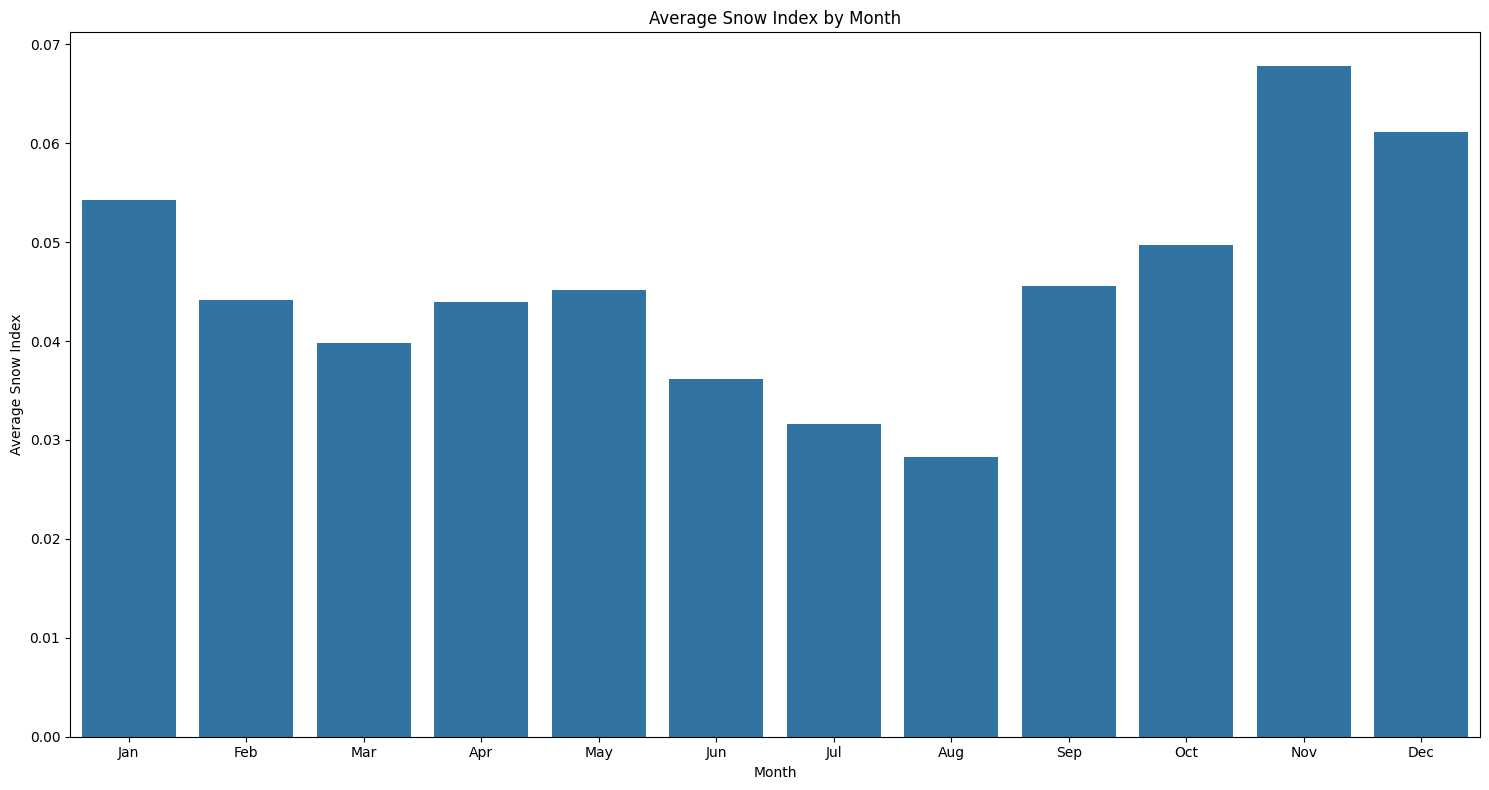

In [40]:
temp_df = dataset_baseline["train"].copy()
temp_df.index = pd.to_datetime(temp_df.index)
temp_df["month"] = temp_df.index.month

final = (
    temp_df.groupby(
        [
            "month",
        ]
    )
    .mean()
    .reset_index()
)

import seaborn as sns


plt.figure(figsize=(15, 10))

plt.figure(figsize=(15, 8))
sns.barplot(
    data=final,
    x="month",
    y="snow_index",
)
plt.title("Average Snow Index by Month")
plt.xlabel("Month")
plt.ylabel("Average Snow Index")
plt.xticks(
    ticks=range(0, 12),
    labels=[
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ],
)

plt.tight_layout()
plt.show()

In [41]:
if "snow_index" and "snow_index_lag" in DATASET_TRANSFORMS:
    for key in dataset_baseline.keys():
        dataset_baseline[key] = add_lagged_features_per_station(
            dataset_baseline[key], features=["snow_index"], lags=4, is_target=True
        )

### **4.2 Data aggregation on temporal data through scope**


### 4.2.1 Executing PCA strategy on specific features


In [42]:
def plot_cumulative_variance_single(
    cumulative_sums,
    title="Cumulative sum of explained variance train set",
):
    plt.plot(cumulative_sums, marker="o")
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Variance")
    plt.grid(True)
    plt.show()

(28431,)
(28431,)
(28431,)
(28431,)
Original train dataset shape (28431, 152)
Original eval dataset shape (1352, 148)
**** Processing

Processing pca dimension reduction on soil_composition, 96 features
(29783, 153)
(29783, 96)
(29783, 96)
(29783, 160)
Only 7 pcs kept, compared to initial 96 values


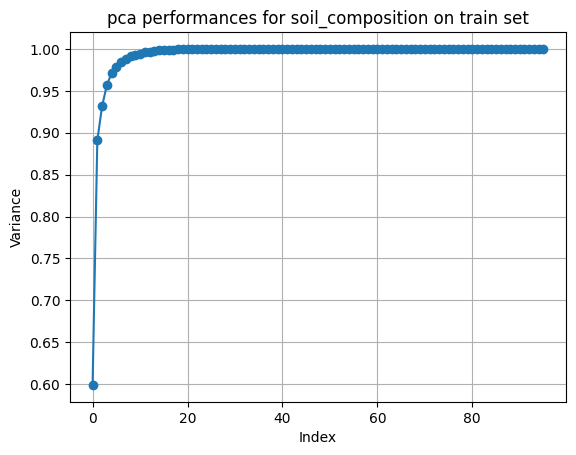

Processing pca dimension reduction on evaporation, 5 features
(29783, 64)
(29783, 5)
(29783, 5)
(29783, 65)
Only 1 pcs kept, compared to initial 5 values


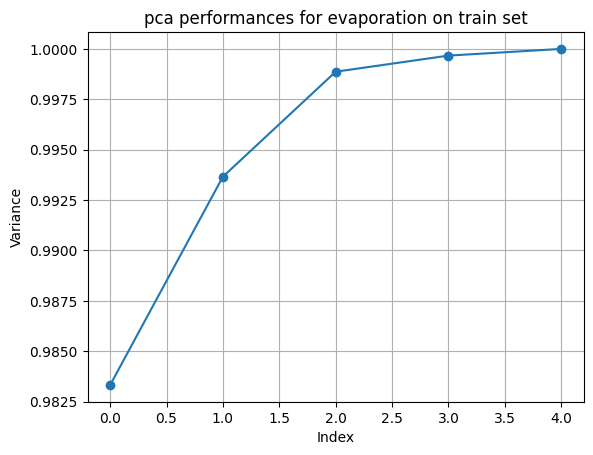

Processing pca dimension reduction on evaporation_lag_1w, 5 features
(29783, 60)
(29783, 5)
(29783, 5)
(29783, 61)
Only 1 pcs kept, compared to initial 5 values


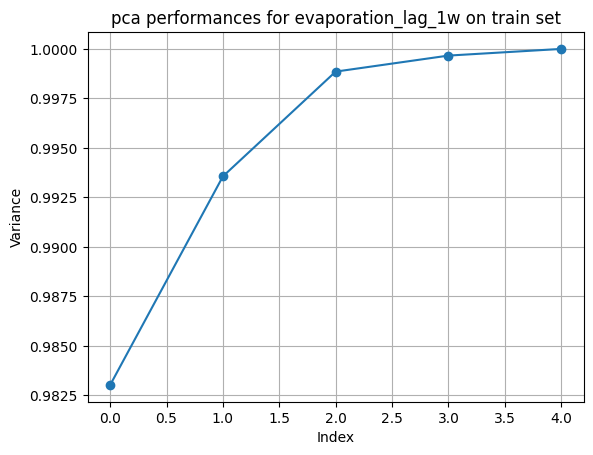

Processing pca dimension reduction on soil_moisture, 5 features
(29783, 56)
(29783, 5)
(29783, 5)
(29783, 59)
Only 3 pcs kept, compared to initial 5 values


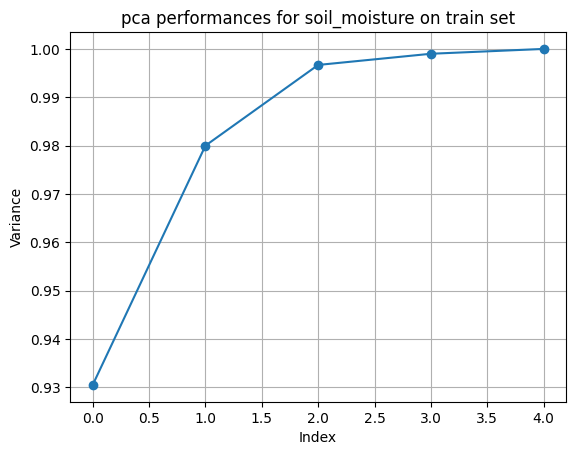

Processing pca dimension reduction on tempartures, 5 features
(29783, 54)
(29783, 5)
(29783, 5)
(29783, 55)
Only 1 pcs kept, compared to initial 5 values


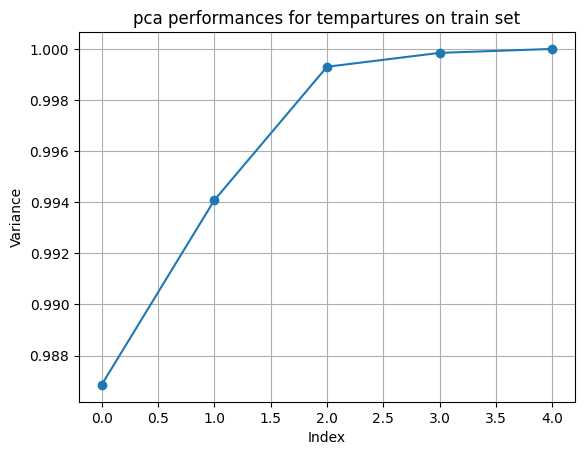

Processing pca dimension reduction on tempartures_lag_1w, 5 features
(29783, 50)
(29783, 5)
(29783, 5)
(29783, 51)
Only 1 pcs kept, compared to initial 5 values


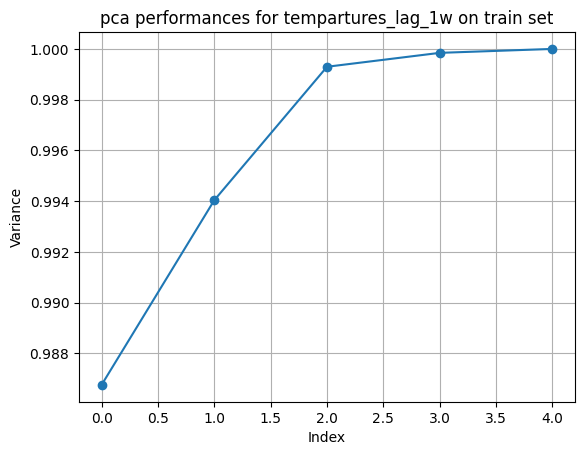

Processing pca dimension reduction on precipitations, 5 features
(29783, 46)
(29783, 5)
(29783, 5)
(29783, 48)
Only 2 pcs kept, compared to initial 5 values


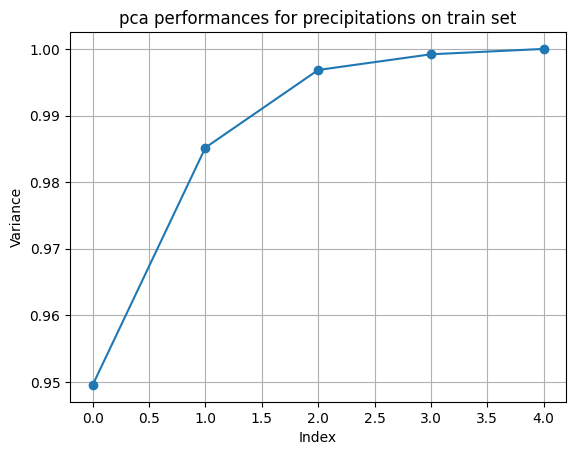

Processing pca dimension reduction on precipitations_lag_1w, 5 features
(29783, 43)
(29783, 5)
(29783, 5)
(29783, 45)
Only 2 pcs kept, compared to initial 5 values


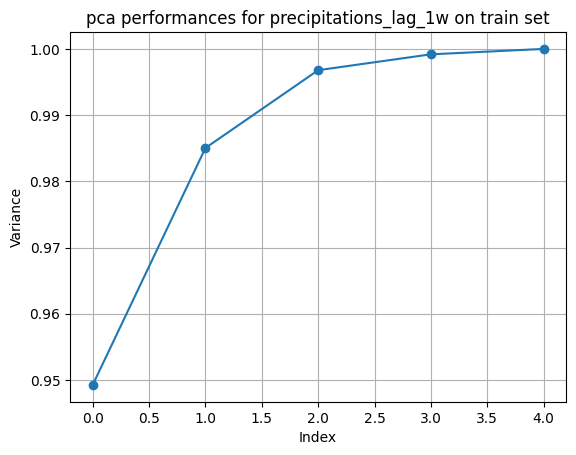

**** END Processing
Final train dataset shape (28431, 39)
Final eval dataset shape (1352, 39)
25.66% of initial features


In [43]:
def find_index_exceeding_threshold(values, threshold=0.98):
    for i, val in enumerate(values):
        if val >= threshold:
            return i
    return -1


def cumulative_sum(arr):
    result = []
    current_sum = 0
    for num in arr:
        current_sum += num
        result.append(current_sum)
    return result


if "pca" in DATASET_TRANSFORMS:

    y_train = {}

    for i in range(0, 4):
        y_train[i] = dataset_baseline["train"][f"water_flow_week{i+1}"]
        print(y_train[i].shape)

    aggregation_lists = {
        "soil_composition": [
            f"{var}_{depth}_mean_index__{scope}"
            for var in ["sand", "bdod", "cfvo", "clay"]
            for depth in [
                "0-5cm",
                "5-15cm",
                "15-30cm",
                "30-60cm",
                "60-100cm",
                "100-200cm",
            ]
            for scope in ["region", "zone", "sector", "sub_sector"]
        ],
        "evaporation": [
            f"evaporation{scope}"
            for scope in ["", "_region", "_zone", "_sector", "_sub_sector"]
        ],
        "evaporation_lag_1w": [
            f"evaporation{scope}_lag_1w"
            for scope in ["", "_region", "_zone", "_sector", "_sub_sector"]
        ],
        "soil_moisture": [
            f"soil_moisture{scope}"
            for scope in ["", "_region", "_zone", "_sector", "_sub_sector"]
        ],
        "tempartures": [
            f"temperature{scope}"
            for scope in ["s", "_region", "_zone", "_sector", "_sub_sector"]
        ],
        "tempartures_lag_1w": [
            f"temperature{scope}_lag_1w"
            for scope in ["s", "_region", "_zone", "_sector", "_sub_sector"]
        ],
        "precipitations": [
            f"precipitation{scope}"
            for scope in ["s", "_region", "_zone", "_sector", "_sub_sector"]
        ],
        "precipitations_lag_1w": [
            f"precipitation{scope}_lag_1w"
            for scope in ["s", "_region", "_zone", "_sector", "_sub_sector"]
        ],
    }

    if "keep_precipitation_and_evaporation" in DATASET_TRANSFORMS:
        del aggregation_lists["precipitations"]
        del aggregation_lists["precipitations_lag_1w"]
        del aggregation_lists["evaporation"]
        del aggregation_lists["evaporation_lag_1w"]

    initial_features_train = dataset_baseline["train"].shape[1]

    print(f"Original train dataset shape {dataset_baseline['train'].shape}")
    print(f"Original eval dataset shape {dataset_baseline['eval'].shape}")
    print("**** Processing")
    print("")

    for list_name, key_list in aggregation_lists.items():
        print(
            f"Processing pca dimension reduction on {list_name}, {len(key_list)} features"
        )

        # This enable having the same pcs numbers on eval and train set
        nbPcsToKeep = -1
        cumulative_sums = 0
        generated_columns = []

        # -----------------------------------------
        dataset_baseline["train"]["origin"] = "train"
        dataset_baseline["eval"]["origin"] = "eval"

        pca_set = pd.concat(
            [
                dataset_baseline["train"],
                dataset_baseline["eval"],
            ],
            ignore_index=False,
        )

        original_index = pca_set.index

        print(pca_set.shape)

        pca = PCA(n_components=len(key_list))
        pca_data = pca.fit_transform(pca_set[key_list])

        cumulative_sums = cumulative_sum(pca.explained_variance_ratio_)

        if nbPcsToKeep == -1:
            nbPcsToKeep = find_index_exceeding_threshold(cumulative_sums, PCA_THRESHOLD)

        print(pca_data.shape)
        pca_df = pd.DataFrame(pca_data, index=original_index)
        print(pca_df.shape)

        pca_df.columns = [f"{list_name}_pca_{i+1}" for i in range(pca_df.shape[1])]
        pca_df = pca_df.iloc[:, : nbPcsToKeep + 1]

        pca_df = pd.concat([pca_df, pca_set], axis=1)

        generated_columns = pca_df.keys()

        print(pca_df.shape)

        dataset_baseline["eval"] = pca_df[pca_df["origin"] == "eval"].copy()
        dataset_baseline["train"] = pca_df[pca_df["origin"] == "train"].copy()

        dataset_baseline["eval"].drop(columns=key_list + ["origin"], inplace=True)
        dataset_baseline["train"].drop(columns=key_list + ["origin"], inplace=True)

        print(
            f"Only {nbPcsToKeep + 1} pcs kept, compared to initial {len(key_list)} values"
        )

        plot_cumulative_variance_single(
            cumulative_sums,
            f"pca performances for {list_name} on train set",
        )

    print("**** END Processing")

    print(f"Final train dataset shape {dataset_baseline['train'].shape}")
    print(f"Final eval dataset shape {dataset_baseline['eval'].shape}")

    print(
        f"{dataset_baseline['train'].shape[1] / initial_features_train * 100:.2f}% of initial features"
    )

### 4.2 Removing data from biaised station


In [44]:
if "rm_gnv_st" in DATASET_TRANSFORMS:
    print(dataset_baseline["train"].shape)
    dataset_baseline["train"] = dataset_baseline["train"][
        dataset_baseline["train"]["station_code"] != 6939050
    ]
    print(dataset_baseline["train"].shape)

(28431, 39)
(27702, 39)


### 4.3 Removing all unique information from station


In [45]:
if "scl_catch" in DATASET_TRANSFORMS:
    raise ValueError(
        "scl_catch is no longer supported as its scaling is included in scl_feat or scl_feat_wl step"
    )
    # scaler = MinMaxScaler()

    # columns_to_scale = ["catchment"]

    # print(f'min :{dataset_baseline["train"][columns_to_scale].min()}')
    # print(f'max :{dataset_baseline["train"][columns_to_scale].max()}')

    # dataset_baseline["train"]["origin"] = "train"
    # dataset_baseline["eval"]["origin"] = "eval"

    # scaling_set = pd.concat([
    #     dataset_baseline["train"],
    #     dataset_baseline["eval"]
    # ], ignore_index=False)

    # scaling_set[columns_to_scale] = scaler.fit_transform(scaling_set[columns_to_scale])

    # dataset_baseline["eval"][columns_to_scale] = scaling_set[scaling_set["origin"] == "eval"][columns_to_scale]
    # dataset_baseline["train"][columns_to_scale] = scaling_set[scaling_set["origin"] == "train"][columns_to_scale]

    # dataset_baseline["eval"].drop(columns=["origin"], inplace=True)
    # dataset_baseline["train"].drop(columns=["origin"], inplace=True)

    # print(f'min :{dataset_baseline["train"][columns_to_scale].min()}')
    # print(f'max :{dataset_baseline["train"][columns_to_scale].max()}')

### 4.4 Encoding month cyclically


In [46]:
if "cyc_enc_date" in DATASET_TRANSFORMS:

    # region duplicate one hot encoding
    for set, dir in datasets.items():
        # Convert the index to datetime and extract the month
        month = pd.to_datetime(dataset_baseline[set].index).month
        is_north = dataset_baseline[set]["north_hemisphere"].astype(bool)

        # Define season mappings
        seasons_north = {
            "is_winter": [12, 1, 2],
            "is_spring": [3, 4, 5],
            "is_summer": [6, 7, 8],
            "is_autumn": [9, 10, 11],
        }

        seasons_south = {
            "is_winter": [6, 7, 8],
            "is_spring": [9, 10, 11],
            "is_summer": [12, 1, 2],
            "is_autumn": [3, 4, 5],
        }

        for season in seasons_north:
            dataset_baseline[set][season] = (
                month.isin(seasons_north[season]) & is_north
                | month.isin(seasons_south[season]) & ~is_north
            )

        # Define month abbreviations and apply monthly flags
        months_abbr = [
            "jan",
            "feb",
            "mar",
            "apr",
            "may",
            "jun",
            "jul",
            "aug",
            "sep",
            "oct",
            "nov",
            "dec",
        ]
        for i, abbr in enumerate(months_abbr, start=1):
            dataset_baseline[set][f"is_{abbr}"] = month == i
    # endregion

    # region method def
    def convert_one_hot_to_label(df, columns, column_name):
        df[column_name] = np.argmax(df[columns].values, axis=1) + 1
        df = df.drop(columns=columns)
        return df

    def encode_cyclical(df, column, max_val, drop_original=True):
        df[f"{column}_sin"] = np.sin(df[column] * (2 * np.pi / max_val))
        df[f"{column}_cos"] = np.cos(df[column] * (2 * np.pi / max_val))

        if drop_original:
            df = df.drop(columns=[column])
        return df

    # endregion

    month_cols = [
        "is_jan",
        "is_feb",
        "is_mar",
        "is_apr",
        "is_may",
        "is_jun",
        "is_jul",
        "is_aug",
        "is_sep",
        "is_oct",
        "is_nov",
        "is_dec",
    ]

    dataset_baseline["train"] = convert_one_hot_to_label(
        dataset_baseline["train"], month_cols, "month"
    )
    dataset_baseline["eval"] = convert_one_hot_to_label(
        dataset_baseline["eval"], month_cols, "month"
    )

    seasons_cols = ["is_winter", "is_spring", "is_summer", "is_autumn"]

    dataset_baseline["train"] = convert_one_hot_to_label(
        dataset_baseline["train"], seasons_cols, "season"
    )
    dataset_baseline["eval"] = convert_one_hot_to_label(
        dataset_baseline["eval"], seasons_cols, "season"
    )

    dataset_baseline["train"] = encode_cyclical(dataset_baseline["train"], "month", 12)
    dataset_baseline["eval"] = encode_cyclical(dataset_baseline["eval"], "month", 12)

    dataset_baseline["train"] = encode_cyclical(dataset_baseline["train"], "season", 4)
    dataset_baseline["eval"] = encode_cyclical(dataset_baseline["eval"], "season", 4)

### 4.5 Clustering on location


In [47]:
sets_name = ["train", "eval"]

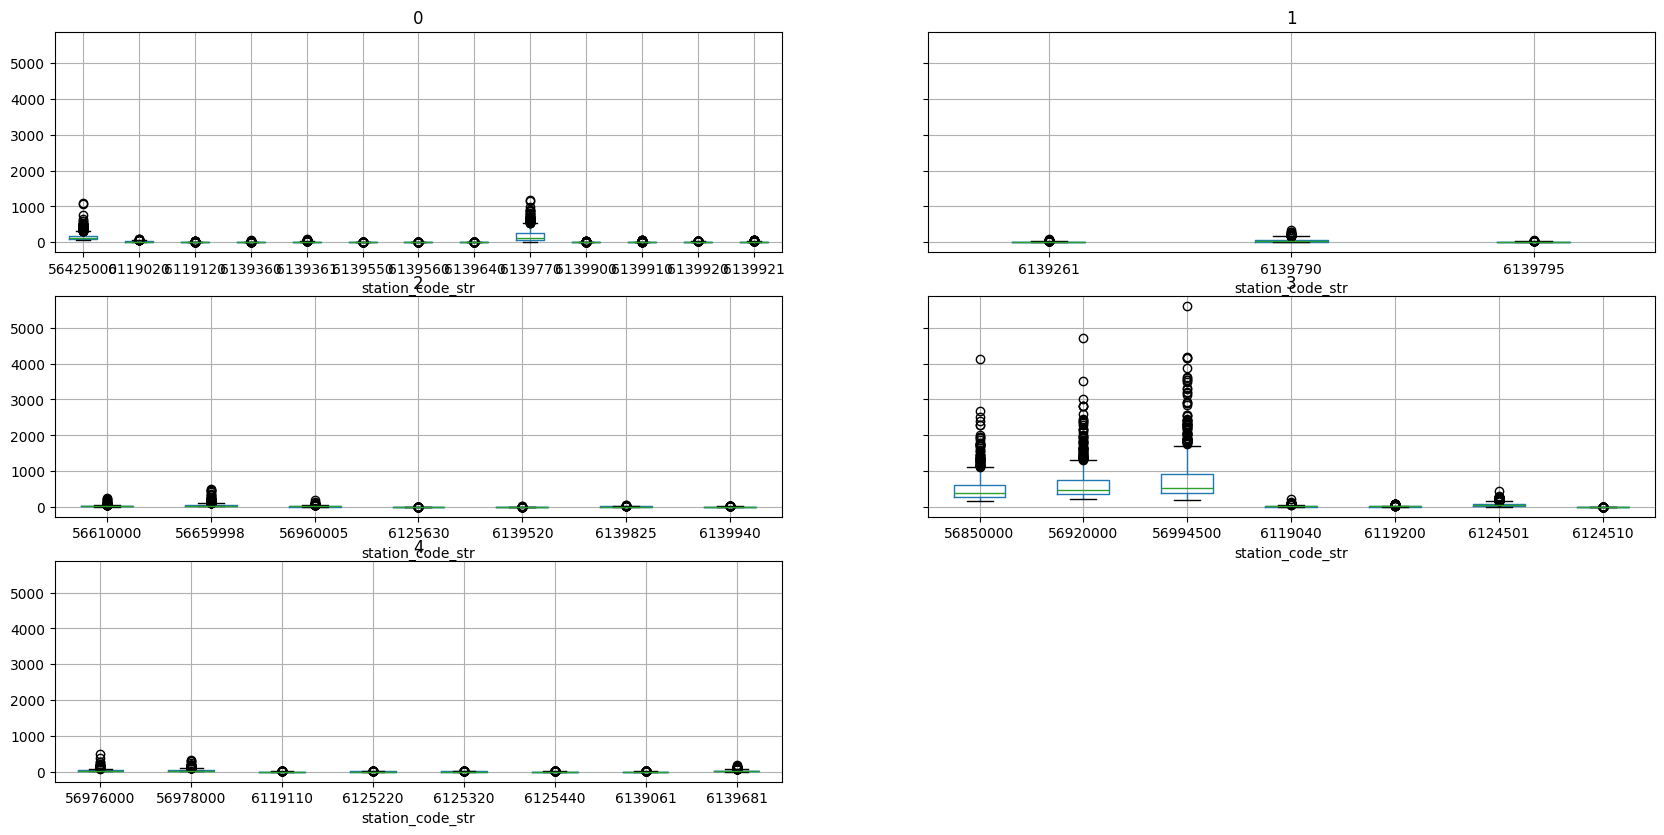

In [48]:
if "clust_index" in DATASET_TRANSFORMS or "clust_index_oh" in DATASET_TRANSFORMS:
    oh_cluster = "clust_index_oh" in DATASET_TRANSFORMS

    geo_features = ["latitude", "longitude", "altitude"]

    kmeans = KMeans(n_clusters=N_CLUSTER, random_state=0).fit(dataset_baseline["train"])

    for set in sets_name:
        if set == "train":
            dataset_baseline[set]["region_cluster"] = kmeans.fit_predict(
                dataset_baseline[set][geo_features]
            )
        else:
            dataset_baseline[set]["region_cluster"] = kmeans.predict(
                dataset_baseline[set][geo_features]
            )

        if oh_cluster:
            print("transforming to one-hot")
            dataset_baseline[set] = pd.get_dummies(
                dataset_baseline[set], columns=["region_cluster"], drop_first=False
            )

    if not oh_cluster:
        dataset_temp = dataset_baseline["train"].copy()

        dataset_temp["station_code_str"] = dataset_temp["station_code"].astype(str)

        dataset_temp.groupby("region_cluster").boxplot(
            column="water_flow_week1", by="station_code_str", figsize=(20, 10)
        )

        plt.xlabel("Station")
        plt.ylabel("Water flow")
        plt.title("Water flow distribution per station")
        plt.suptitle("")
        plt.show()

### 4.6 Clustering on waterflow and catchment


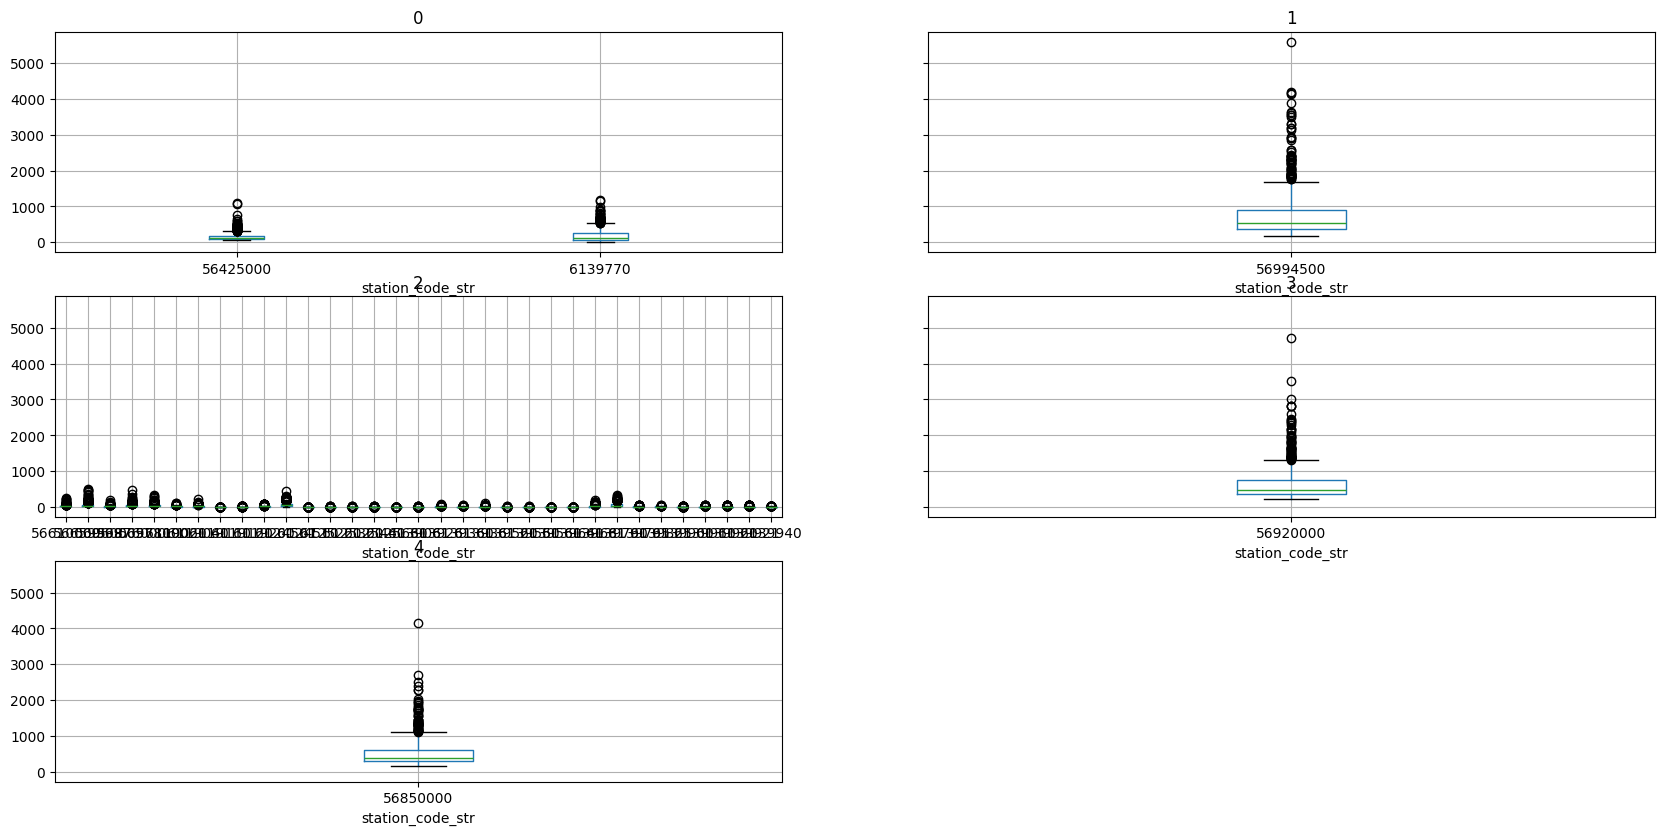

In [49]:
if "clust_hydro" in DATASET_TRANSFORMS or "clust_hydro_oh" in DATASET_TRANSFORMS:
    oh_cluster = "clust_hydro_oh" in DATASET_TRANSFORMS

    hydro_features = ["catchment", "water_flow_lag_1w", "water_flow_lag_2w"]

    kmeans = KMeans(n_clusters=N_CLUSTER, random_state=0).fit(dataset_baseline["train"])

    for set in sets_name:
        if set == "train":
            dataset_baseline[set]["hydro_cluster"] = kmeans.fit_predict(
                dataset_baseline[set][hydro_features]
            )
        else:
            dataset_baseline[set]["hydro_cluster"] = kmeans.predict(
                dataset_baseline[set][hydro_features]
            )

        if oh_cluster:
            print("transforming to One-hot")
            dataset_baseline[set] = pd.get_dummies(
                dataset_baseline[set], columns=["hydro_cluster"], drop_first=False
            )

    if not oh_cluster:
        dataset_temp = dataset_baseline["train"].copy()

        dataset_temp["station_code_str"] = dataset_temp["station_code"].astype(str)

        dataset_temp.groupby("hydro_cluster").boxplot(
            column="water_flow_week1", by="station_code_str", figsize=(20, 10)
        )

        plt.xlabel("Station")
        plt.ylabel("Water flow")
        plt.title("Water flow distribution per station")
        plt.suptitle("")
        plt.show()

### 4.7 Remove custom waterflow lag


In [50]:
if "rm_wl" in DATASET_TRANSFORMS:
    for set, dir in datasets.items():
        dataset_baseline[set] = dataset_baseline[set].drop(
            columns=["water_flow_lag_3w", "water_flow_lag_4w"]
        )

### 4.8 Select mobile average


In [51]:
if "slct_ma" in DATASET_TRANSFORMS:

    original_list = [
        "water_flow_ma_4w_lag_1w",
        "water_flow_ma_3w_lag_1w",
        "water_flow_ma_2w_lag_1w",
        "water_flow_ma_4w_lag_1w_gauss",
        "water_flow_ma_3w_lag_1w_gauss",
        "water_flow_ma_2w_lag_1w_gauss",
    ]
    cols_to_drop = [
        item for item in original_list if item not in SELECTED_MOBILE_AVERAGE
    ]

    for set, dir in datasets.items():
        dataset_baseline[set] = dataset_baseline[set].drop(columns=cols_to_drop)

### 4.9 Add lag slope


In [52]:
if "lag_slope" in DATASET_TRANSFORMS:
    for set, dir in datasets.items():
        print(f"Processing {set} set")
        dataset_baseline[set]["water_flow_evolve_slope"] = (
            dataset_baseline[set]["water_flow_lag_1w"]
            - dataset_baseline[set]["water_flow_lag_2w"]
        ) / dataset_baseline[set]["water_flow_lag_2w"].replace(0, 1)

Processing train set
Processing eval set


### 4.10 Add target precipitation for training


In [53]:
if "target_precipitation" in DATASET_TRANSFORMS:
    dataset_baseline["train"] = add_lagged_features_per_station(
        dataset_baseline["train"],
        features=["precipitations_pca_1"],
        lags=4,
        is_target=True,
    )

## 5. Data Saving, and Visualization


Saves the complete baseline.


In [54]:
for set, dir in datasets.items():
    dataset_baseline[set].to_csv(f"{dir}dataset_{DATASET_NAME}.csv")

Visualizes the water flow for the 10 first stations.


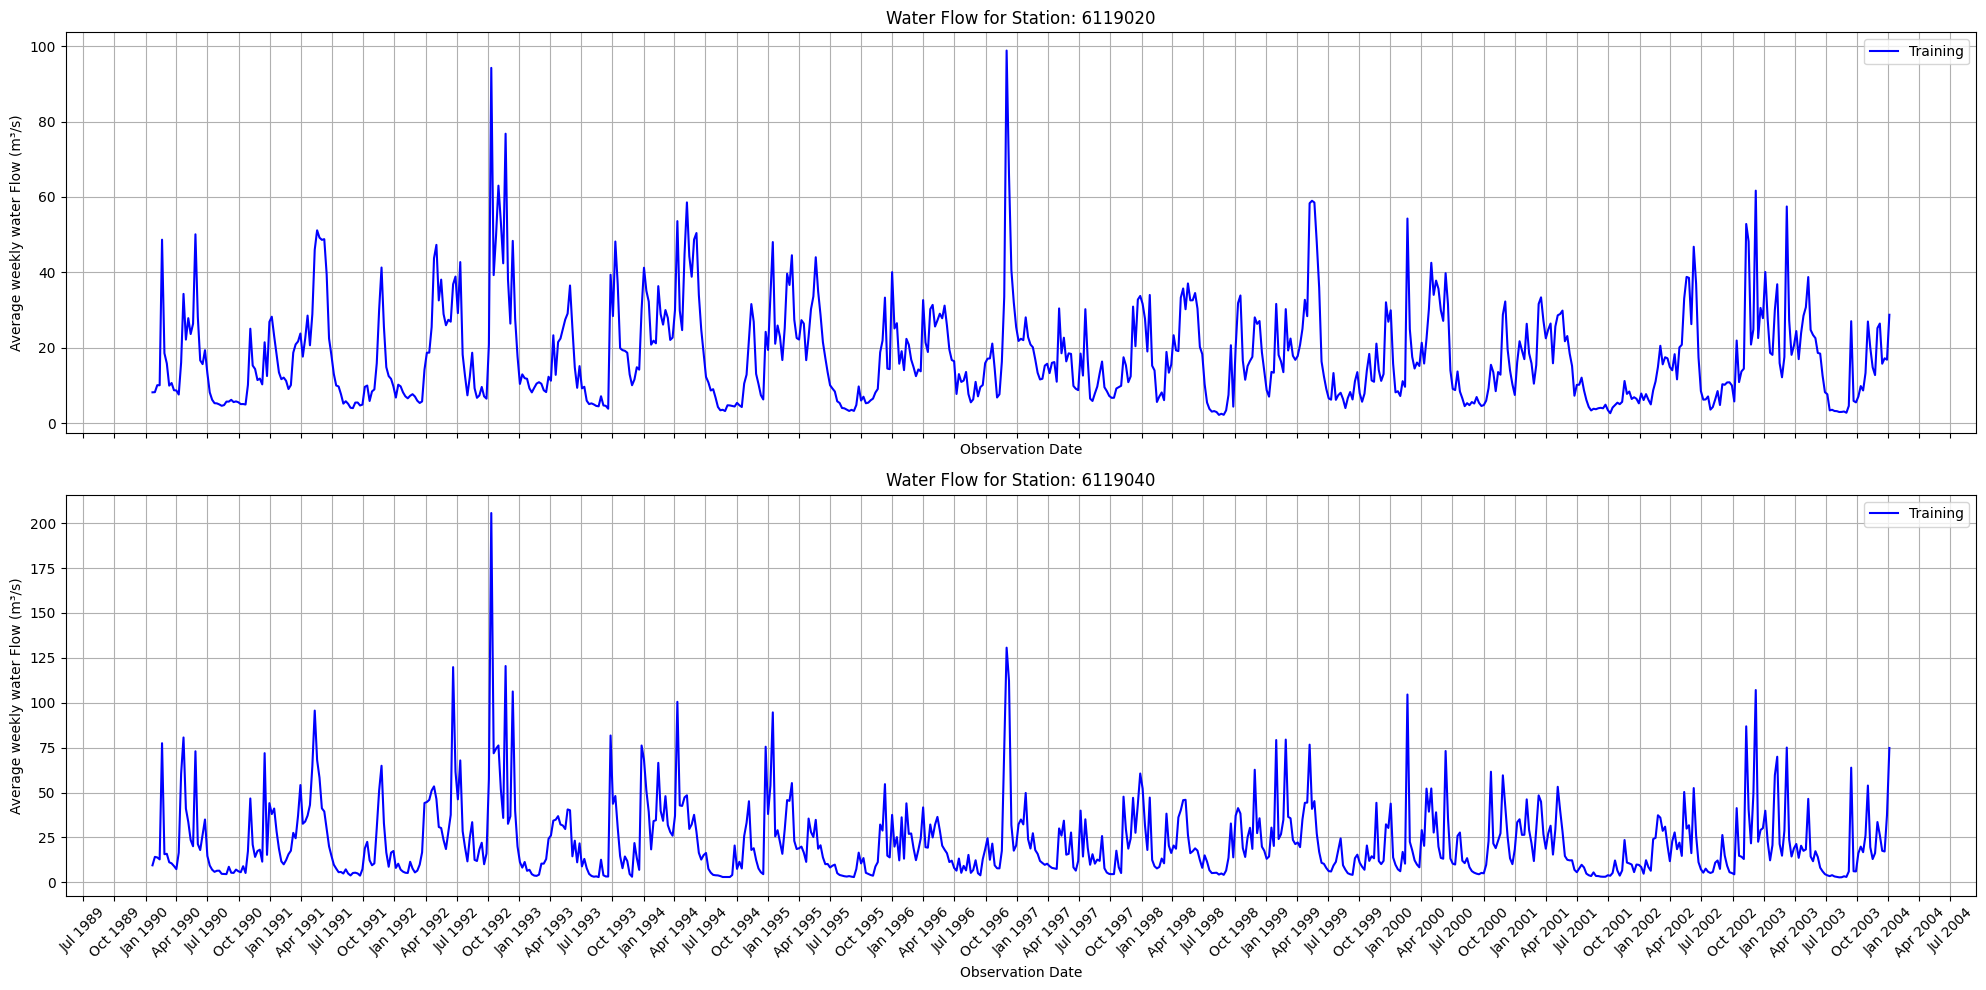

In [55]:
plot_water_flows(dataset_baseline["train"], max_stations=2, display=True, save=False)